## Population dynamics
This code examines how population of neurons change their firing patterns across time using dimensionality reduction and network dynamics analysis

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt  

from datetime import date
import time

import h5py

In [3]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [4]:
mother_path = Path('D:/Multi-modal project/')
fig_path = mother_path / 'analysis' / 'result' / 'figures'

### Parameter setting

In [192]:
# colors for multimodal, vis-only, aud-only conditions
color = ['tab:purple','tab:blue','tab:red','tab:green']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [7]:
cell_path = mother_path/'analysis'/'result'/'zFR export'/'13-Jun-2023'
cell_list = os.listdir(cell_path)

# load hdf5 files containing shuffled results
data_path = mother_path /'analysis'/'result'/'3. ANOVA'/'2023-07-05'
data2_path = mother_path /'analysis'/'result'/'3.1 Multiple linear regression'/'2023-07-05'
f = h5py.File(data_path/'2023-07-05_ANOVA_result.hdf5','r')
f2 = h5py.File(data2_path/'2023-07-05_multiple_regression_result.hdf5','r')

In [8]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [9]:
df = h5_to_df(f)
df = df[df['Region']=='PER']
df.reset_index(inplace=True, drop=True)

for key in df['key']:
    if df.loc[df['key']==key, 'Object cell'].item() == 0:
        df.loc[df['key']==key, 'Category'] = 'none'
    else:
        if f2[key].attrs['Response cell'] == 0:
            df.loc[df['key']==key, 'Category'] = 'object'
        else:
            df.loc[df['key']==key, 'Category'] = 'response'

### Examine the number of neurons available for population analysis

In [29]:
rat_list = np.sort(df['Rat'].unique())
print(rat_list)

['600' '602' '640' '647' '654' '679' '699']


In [44]:
# none cell + object cell (response cell excluded)
cell_array = np.zeros((len(rat_list),int(df['Session'].max())))
for i in range(len(df)):
    rat = df.loc[i, 'Rat']
    rat_id = np.where(rat_list==rat)[0][0]
    ss = int(df.loc[i, 'Session'])
    
    if df.loc[i,'Category'] != 'response':
        cell_array[rat_id, ss-1] += 1

print('===== Object cells + None =====')        
print(cell_array)

===== Object cells + None =====
[[ 9. 11.  3. 11.  7.  0.  0.]
 [26. 19. 28. 16. 16.  0.  0.]
 [10. 13.  9.  4.  5.  0.  0.]
 [ 0.  0.  0. 15. 10.  8.  4.]
 [ 7.  4.  0.  0.  1.  0.  0.]
 [ 0.  2.  2.  3.  0.  1.  0.]
 [ 9.  9. 16. 15. 17.  7.  0.]]


In [45]:
# only object cell (response cell, none cell excluded)
cell_array = np.zeros((len(rat_list),int(df['Session'].max())))
for i in range(len(df)):
    rat = df.loc[i, 'Rat']
    rat_id = np.where(rat_list==rat)[0][0]
    ss = int(df.loc[i, 'Session'])
    
    if df.loc[i,'Category'] == 'object':
        cell_array[rat_id, ss-1] += 1

print('====== Only object cells ======')
print(cell_array)

====== Only object cells ======
[[ 6.  6.  2.  4.  5.  0.  0.]
 [15.  6. 10.  5.  8.  0.  0.]
 [ 7.  9.  4.  3.  3.  0.  0.]
 [ 0.  0.  0. 10.  4.  4.  4.]
 [ 3.  2.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  1.  0.  0.  0.]
 [ 4.  3.  6.  3.  8.  3.  0.]]


In [21]:
num_obj = np.sum(cell_array,axis=1)
for i in range(len(rat_list)):
    print(f'LE{rat_list[i]}: {int(num_obj[i])}')

LE600: 23
LE602: 44
LE640: 26
LE647: 22
LE654: 6
LE679: 2
LE699: 27


### Neural population dynamics

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

rat_list2 = rat_list[[0,1,2,3,6]]    # pick rats with enough samples
rat = rat_list2[1]

In [258]:
def neural_state_PCA(rat, bin_size, num_PC):
    
    scaler = StandardScaler()   

    object_cell_list = df.loc[(df['Category']=='object')&(df['Rat']==rat),'key']
    num_bin = int(90/bin_size)
    
    pop_mat = np.zeros((int(8*num_bin),len(object_cell_list)))
    for i, key in enumerate(object_cell_list):
        key = key.zfill(4)
        cell_filename = list(cell_path.glob(f'{key}*.csv'))
        df_cell = pd.read_csv(cell_filename[0])
        df_cell.drop(df_cell[df_cell.Correctness==0].index,inplace=True)
        df_cell.reset_index(inplace=True,drop=True)
        
        boy_goal = df_cell.loc[df_cell['Visual']=='Boy','RWD_Loc'].values[0]
        egg_goal = df_cell.loc[df_cell['Visual']=='Egg','RWD_Loc'].values[0]

        cond = [(df_cell.Type=='Multimodal')&(df_cell.RWD_Loc==boy_goal),
                (df_cell.Type=='Visual')&(df_cell.RWD_Loc==boy_goal),
                (df_cell.Type=='Auditory')&(df_cell.RWD_Loc==boy_goal),
                (df_cell.Type=='Multimodal')&(df_cell.RWD_Loc==egg_goal),
                (df_cell.Type=='Visual')&(df_cell.RWD_Loc==egg_goal),
                (df_cell.Type=='Auditory')&(df_cell.RWD_Loc==egg_goal),
                (df_cell.Type=='Elemental')&(df_cell.RWD_Loc==boy_goal),
                (df_cell.Type=='Elemental')&(df_cell.RWD_Loc==boy_goal)]
        
        fr_id = df_cell.columns.get_loc('Var10')  # get the index of the first firing rate column
        
        for c in range(len(cond)):
            bin_FR = np.zeros(bin_size)
            cond_FR = df_cell[cond[c]].iloc[:,fr_id:fr_id+90].to_numpy()
            for b in range(num_bin):
                pop_mat[num_bin*c+b,i] = np.mean(cond_FR[:,bin_size*b:bin_size*(b+1)])
                
        #pop_mat[:,i] = scaler.fit_transform([pop_mat[:,i]])
          
    pop_mat = scaler.fit_transform(pop_mat)
    
    pca = PCA(n_components=num_PC)
    pca.fit(pop_mat)
    PCA_result = pca.transform(pop_mat)
        
    return PCA_result

In [273]:
bin_size = 10
num_bin = int(90/bin_size)
PCA_result = neural_state_PCA('602', bin_size, 2)
print(np.shape(PCA_result))

(72, 2)


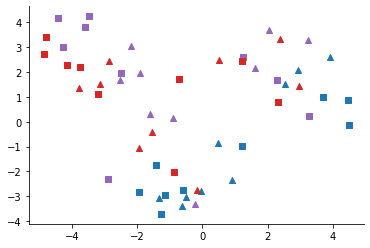

In [274]:
# Plot the transformed data in 2D
for i in range(3):
    plt.scatter(PCA_result[num_bin*i:num_bin*(i+1),0],
                PCA_result[num_bin*i:num_bin*(i+1),1], color=color[i], marker='s')
for i in [3,4,5]:
    plt.scatter(PCA_result[num_bin*i:num_bin*(i+1),0],
                PCA_result[num_bin*i:num_bin*(i+1),1], color=color[i-3], marker='^')

In [ ]:
fig,ax = plt.subplots()